In [3]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split


In [3]:
o2 = pd.read_csv(o2_path)
cdh = pd.read_csv(cdh_path,index_col=0)

In [4]:
cdh['Intubation_flag'].value_counts(dropna=False)

1    4067
0    1747
Name: Intubation_flag, dtype: int64

In [5]:
cdh['extubation_status'] = ['extubated' if x == 0 else 'intubated' for x in cdh.Intubation_flag]

In [6]:
cdh['extubation_status'].value_counts(dropna=False)

intubated    4067
extubated    1747
Name: extubation_status, dtype: int64

In [7]:
o2['RECORDED_TIME'] = pd.to_datetime(o2['RECORDED_TIME'])
o2['recorded_day'] = [np.datetime_as_string(x, unit='D') for x in o2['RECORDED_TIME'].values]

In [8]:
o2['patient_calendar_day'] = [str(r.ir_id) + '/' + str(r.recorded_day) for i,r in o2.iterrows()]

In [9]:
cdh['patient_calendar_day'] = [str(r.ir_id) + '/' + str(r.day_bucket_starts) for i,r in cdh.iterrows()]

In [10]:
patient_day_map = {
    r.patient_calendar_day:r.patient_day for i,r in cdh.iterrows()
}
o2['patient_day'] = o2['patient_calendar_day'].map(patient_day_map)

In [11]:
new_status_dict = {
    r.patient_day:r.extubation_status for i,r in cdh.iterrows()
}
o2['extubation_status'] = o2['patient_day'].map(new_status_dict)

In [12]:
o2.drop_duplicates(subset='patient_day').extubation_status.value_counts()

intubated    4066
extubated    1738
Name: extubation_status, dtype: int64

In [14]:
# cdh[~cdh.patient_day.isin(o2.patient_day)]

Only 10 days missing from O2 report. Check these again at the end.

In [15]:
missing_days = cdh[~cdh.patient_day.isin(o2.patient_day)].patient_day.values

## Check for intubated days that are mis-annotated

In [16]:
o2.recorded_day = pd.to_datetime(o2.recorded_day)

In [17]:
o2['time_of_day'] = [x.astype('datetime64[s]').astype(object).time() for x in o2.RECORDED_TIME.values]

In [18]:
o2 = o2.sort_values(by=['ir_id','recorded_day','RECORDED_TIME'])

Check for intubated days that aren't all intubated or don't have at least three markers

In [19]:
def check_intubation(sub):
    # keep simple
    if len(sub) > 0:
        vent_display = ((sub.DISP_NAME == 'O2 Device') & (sub.MEAS_VALUE == 'Ventilator'))
        vent_yes = (sub.DISP_NAME == 'Ventilator')
        if np.all(vent_display | vent_yes):
            return True
        else:
            cts = np.where(vent_display | vent_yes)[0]
            return len(cts) >= 3

In [20]:
flagged_intub = []
intub_days = cdh[cdh.Intubation_flag == 1].patient_day.unique()
for day in intub_days:
    sub = o2[
        (o2.patient_day == day) & (o2['time_of_day'] < datetime.time(8, 0))
    ]
    if not check_intubation(sub):
        flagged_intub.append(day)

In [21]:
len(flagged_intub)

40

In [22]:
# o2[o2.patient_day == flagged_intub[11]]

These are as expected- cases of partial intubation. Often times a patient is intubated before 8am, or sometimes there's a one off label like a RSBI trial, or there's an extubation event. If the previous day was ectubated, then I'll label as early intubation and we wouldn't use this day but the next for modeling. Other cases will leave as is.

In [23]:
early_intub = []
for d in flagged_intub:
    pt_stay = d.rsplit('/',1)[0]
    prev_day = int(d.rsplit('/',1)[1]) - 1
    prev_day = f"{pt_stay}/{prev_day}"
    if prev_day not in list(cdh.patient_day.unique()):
        early_intub.append(d)
    else:
        prev_day_status = cdh[cdh.patient_day == prev_day].extubation_status.values[0]
        if prev_day_status == 'extubated':
            early_intub.append(d)

In [24]:
len(early_intub)

26

In [25]:
# o2[o2.patient_day == early_intub[2]]

Looks good

In [26]:
cdh.loc[cdh.patient_day.isin(early_intub),'extubation_status'] = 'early intubation'

In [27]:
cdh.extubation_status.value_counts(dropna=False)

intubated           4041
extubated           1747
early intubation      26
Name: extubation_status, dtype: int64

Check for extubation events on intubated days

In [28]:
def check_extubation(sub):
    extub_yes = ((sub.DISP_NAME == "Extubation") & (sub.MEAS_VALUE == "Yes"))
    vent_dc = ((sub.DISP_NAME == 'Vent D/C') | (sub.DISP_NAME == 'Vent D/C Time'))

    return np.any(extub_yes | vent_dc)

In [29]:
flag_extub = []
intub_days = cdh[cdh.Intubation_flag == 1].patient_day.unique()
for day in intub_days:
    sub = o2[
        (o2.patient_day == day) & (o2['time_of_day'] < datetime.time(8, 0))
    ]
    if check_extubation(sub):
        flag_extub.append(day)

In [30]:
len(flag_extub)

21

In [31]:
# o2[o2.patient_day == flag_extub[2]]

In [32]:
cdh.loc[cdh.patient_day.isin(flag_extub),'extubation_status'] = 'early extubation'

Update: label early intubation and extubation both as 0 under Intubation_flag

In [33]:
cdh[['extubation_status','Intubation_flag']].value_counts()

extubation_status  Intubation_flag
intubated          1                  4020
extubated          0                  1747
early intubation   1                    26
early extubation   1                    21
dtype: int64

In [34]:
cdh['Intubation_flag'] = [1 if x == 'intubated' else 0 for x in cdh.extubation_status]

In [35]:
cdh[['extubation_status','Intubation_flag']].value_counts()

extubation_status  Intubation_flag
intubated          1                  4020
extubated          0                  1747
early intubation   0                    26
early extubation   0                    21
dtype: int64

## Check for extubated days that are mis-annotated

In [36]:
# either all ventilation, or at least three signs of ventilation

def check_intubation(sub):
    # keep simple
    if len(sub) > 0:
        vent_display = ((sub.DISP_NAME == 'O2 Device') & (sub.MEAS_VALUE == 'Ventilator'))
        vent_yes = (sub.DISP_NAME == 'Ventilator')
        if np.all(vent_display | vent_yes):
            return True
        else:
            cts = np.where(vent_display | vent_yes)[0]
            return len(cts) >= 3

In [37]:
flag_intub = []
extub_days = cdh[cdh.extubation_status == 'extubated'].patient_day.unique()
for day in extub_days:
    sub = o2[
        (o2.patient_day == day) & (o2['time_of_day'] < datetime.time(8, 0))
    ]
    if check_intubation(sub):
        flag_intub.append(day)

In [38]:
len(flag_intub)

152

In [39]:
# o2[o2.patient_day == flag_intub[4]]

These should all be intubated

In [40]:
cdh.loc[cdh.patient_day.isin(flag_intub),'extubation_status'] = 'intubated'

In [41]:
cdh['Intubation_flag'] = [1 if x == 'intubated' else 0 for x in cdh.extubation_status]

In [42]:
cdh[['extubation_status','Intubation_flag']].value_counts()

extubation_status  Intubation_flag
intubated          1                  4172
extubated          0                  1595
early intubation   0                    26
early extubation   0                    21
dtype: int64

## Label fail if reintubated within two days

In [43]:
df = cdh.copy()

In [44]:
def first_intubation_date(x):
    r = x.loc[x.Intubation_flag.eq(1)].head(1)
    if r.shape[0]:
        return r.day_bucket_starts.values[0]
    return np.nan

In [45]:
first_intub_by_pt_stay = df.groupby(['ir_id', 'stay']).apply(first_intubation_date)

In [46]:
THRESHOLD = 2
for k, df_slice in df.groupby(['ir_id', 'stay']):
    intub = False
    prev_slice = None
    for _, intub_slice in df_slice.groupby(
        (df_slice.Intubation_flag.shift() != df_slice.Intubation_flag).cumsum()
    ):
        intub_flag = intub_slice.Intubation_flag.values[0] == 1
        if intub_flag:
            # df.loc[intub_slice.index, 'extubation_status'] = 'intubated'
            if intub and prev_slice is not None and prev_slice.shape[0] <= THRESHOLD:
                df.loc[prev_slice.index, 'extubation_status'] = 'failed'
            intub = True
        else:
            if intub:
                # check next stay intubation date against the current
                cur_pt = df_slice.ir_id.values[0]
                cur_stay = df_slice.stay.values[0]
                cur_date = pd.to_datetime(intub_slice.day_bucket_starts).values[0]
                next_stay_key = (cur_pt, cur_stay + 1)
                if next_stay_key in first_intub_by_pt_stay.index:
                    next_intub_date = pd.to_datetime(first_intub_by_pt_stay[next_stay_key])
                    delta = (next_intub_date - cur_date).days
                    if delta <= THRESHOLD:
                        df.loc[intub_slice.index, 'extubation_status'] = 'failed'
                    else:
                        pass
                        # df.loc[intub_slice.index, 'extubation_status'] = 'successful'
                else:
                    pass
                    # df.loc[intub_slice.index, 'extubation_status'] = 'successful'
            else:
                pass
                # df.loc[intub_slice.index, 'extubation_status'] = 'preintubation'
        prev_slice = intub_slice

In [47]:
df.extubation_status.value_counts()

intubated           4172
extubated           1565
failed                36
early intubation      24
early extubation      17
Name: extubation_status, dtype: int64

In [48]:
fails = df[df.extubation_status == 'failed'].patient_day.values

In [49]:
def examine_fail(df,day):
    num_day = day.rsplit('/',1)[1]
    start_str = day.rsplit('/',1)[0]
    trail_day = f"{start_str}/{int(num_day)+1}"
    trail_day_2 = f"{start_str}/{int(num_day)+2}"
    lead_day = f"{start_str}/{int(num_day)-1}"
    return df[df.patient_day.isin([lead_day,day,trail_day,trail_day_2])][['Intubation_flag','extubation_status']]

In [50]:
# examine_fail(fails[8])

These look good to go

In [51]:
cdh.extubation_status = df.extubation_status.values

### Label CMO

Pull death info from separate sheet

In [52]:
endpoints = pd.read_csv(endpoints_path)

In [53]:
endpoints.death_date = pd.to_datetime(endpoints.death_date)

In [54]:
endpoints = endpoints[endpoints.death_date.notnull()].drop_duplicates(subset='ir_id')

In [55]:
cdh = cdh.merge(
    endpoints[['ir_id','death_date']],
    on='ir_id',
    how='left'
)

In [56]:
cdh.drop_duplicates(subset='ir_id').death_date.isnull().value_counts()

False    241
True     211
Name: death_date, dtype: int64

### If extubated within two days of death, then labels as dni (show histogram)

In [57]:
cdh[['extubation_status','Intubation_flag']].value_counts()

extubation_status  Intubation_flag
intubated          1                  4172
extubated          0                  1565
failed             0                    36
early intubation   0                    24
early extubation   0                    17
dtype: int64

In [58]:
df = cdh.set_index('patient_day')

In [59]:
def first_day_last_extub_fun(x):
    last = x.iloc[-1, :]
    if last.extubation_status not in ['extubated','early extubation']:
        return
    # find first row of last stretch of extubation
    i = None
    for idx in reversed(x.index):
        if x.loc[idx].Intubation_flag == 1:
            break
        i = idx
    return x.loc[i]
    
first_day_last_extub = df.groupby(['ir_id']).apply(first_day_last_extub_fun)

In [60]:
first_day_last_extub = first_day_last_extub[first_day_last_extub.ir_id.notnull()]
first_day_last_extub.stay = first_day_last_extub.stay.astype(int)
first_day_last_extub.day = first_day_last_extub.day.astype(int)
first_day_last_extub.index = (
    first_day_last_extub.ir_id.astype(int).astype(str)
    + '/' + first_day_last_extub.stay.astype(int).astype(str)
    + '/' + first_day_last_extub.day.astype(int).astype(str)
)

first_day_last_extub['death_date'] = pd.to_datetime(
    df.death_date[first_day_last_extub.index]
)
first_day_last_extub['day_bucket_starts'] = pd.to_datetime(
    df.day_bucket_starts[first_day_last_extub.index]
)
first_day_last_extub['time_to_death'] = (
    first_day_last_extub.death_date - first_day_last_extub.day_bucket_starts
).dt.days

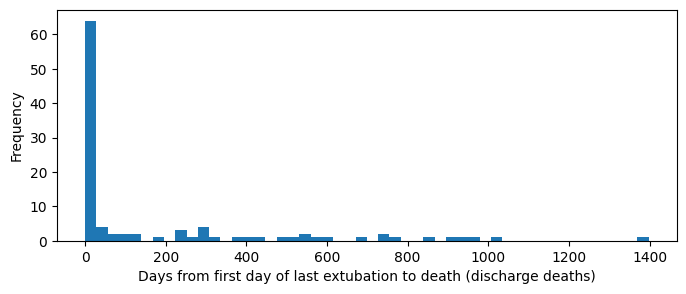

In [61]:
fig, ax = plt.subplots(figsize=(8, 3))
discharge_deaths = first_day_last_extub[first_day_last_extub.death_date.notnull()]
discharge_deaths.time_to_death.plot.hist(bins=50,ax=ax)
ax.set_xlabel('Days from first day of last extubation to death (discharge deaths)')
plt.show()

In [62]:
len(discharge_deaths)

103

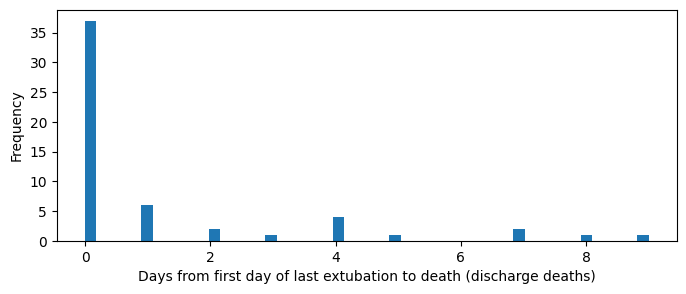

In [63]:
fig, ax = plt.subplots(figsize=(8, 3))
discharge_deaths[discharge_deaths.time_to_death < 10].time_to_death.plot.hist(bins=50,ax=ax)
ax.set_xlabel('Days from first day of last extubation to death (discharge deaths)')
plt.show()

If within two days, flag as CMO

In [64]:
non_dni_early_deaths = first_day_last_extub.loc[
    first_day_last_extub.time_to_death.le(THRESHOLD)
]

In [65]:
len(non_dni_early_deaths)

45

In [66]:
for i, r in non_dni_early_deaths.iterrows():
    pt_day = r.day
    while True:
        i = f"{int(r.ir_id)}/{int(r.stay)}/{int(pt_day)}"
        pt_stay = f"{int(r.ir_id)}/{int(r.stay)}"
        if pt_day > df[df.Patient_id_2 == pt_stay].day.max() or df.Intubation_flag[i] == 1:
            break
        df.loc[i, 'extubation_status'] = 'suspected dni'
        pt_day += 1

In [67]:
df.extubation_status.value_counts(dropna=False)

intubated           4172
extubated           1525
suspected dni         50
failed                36
early intubation      24
early extubation       7
Name: extubation_status, dtype: int64

In [68]:
dni_days = df[df.extubation_status == 'suspected dni'].index.values

In [69]:
# df[df.extubation_status == 'suspected dni'].Patient_id_2.value_counts()

In [70]:
df.patient_day = df.index

## Same-day fails

In [72]:
def check_failed_extubation(sub):
    if len(sub) == 0:
        return False
    extub_yes = ((sub.DISP_NAME == "Extubation") & (sub.MEAS_VALUE == "Yes"))
    vent_dc = ((sub.DISP_NAME == 'Vent D/C') | (sub.DISP_NAME == 'Vent D/C Time'))
    extub_check =  np.where(extub_yes | vent_dc)[0]

    vent_display = ((sub.DISP_NAME == 'O2 Device') & (sub.MEAS_VALUE == 'Ventilator'))
    vent_yes = (sub.DISP_NAME == 'Ventilator')
    intub_yes = np.where(vent_display | vent_yes)[0]

    pt_day = sub.patient_day.values[0]
    stay = pt_day.rsplit('/',1)[0]
    day = pt_day.rsplit('/',1)[1]
    next_day = f"{stay}/{int(day)+1}"
    if next_day in list(cdh.patient_day):
        next_day_status = cdh[cdh.patient_day == next_day].extubation_status.values[0]
    else:
        next_day_status = 'missing'


    # at least three markers of intubation after extubation
    if len(extub_check) > 0:
        if next_day_status == 'intubated':
            return True
        elif len(intub_yes) > 0: 
            num_greater = len([x for x in intub_yes if x > max(extub_check)])
            return num_greater >= 3
        else:
            return False
    else:
        return False

In [73]:
check_fail = []
intub_days = cdh[cdh.extubation_status == 'intubated'].patient_day.unique()
for day in intub_days:
    sub = o2[(o2.patient_day == day) & (o2['time_of_day'] >= datetime.time(8, 0))]
    if check_failed_extubation(sub):
        check_fail.append(day)

In [74]:
len(check_fail)

14

In [75]:
# o2[o2.patient_day == check_fail[4]]

In [76]:
cdh.extubation_status = df.extubation_status.values

In [77]:
cdh.loc[cdh.patient_day.isin(check_fail),'extubation_status'] = 'same-day fail'

In [78]:
cdh.Intubation_flag = [1 if x == 'intubated' else 0 for x in cdh.extubation_status]

In [79]:
cdh[['extubation_status','Intubation_flag']].value_counts()

extubation_status  Intubation_flag
intubated          1                  4158
extubated          0                  1525
suspected dni      0                    50
failed             0                    36
early intubation   0                    24
same-day fail      0                    14
early extubation   0                     7
dtype: int64

## Preintubated days

In [80]:
preintub_days = []
for p in cdh.Patient_id_2.unique():
    sub = cdh[cdh.Patient_id_2 == p]
    pt_day = sub.day.values[0]
    i = sub.patient_day.values[0]
    while pt_day <= sub.day.max() and sub[sub.patient_day == i].Intubation_flag.values[0] == 0:
        preintub_days.append(i)
        pt_day += 1
        i = f"{p}/{pt_day}"

In [81]:
len(preintub_days)

787

In [82]:
len(cdh)

5814

In [83]:
cdh.loc[cdh.patient_day.isin(preintub_days),'extubation_status'] = 'preintubated'

In [84]:
cdh.extubation_status.value_counts()

intubated           4158
preintubated         787
extubated            778
failed                36
suspected dni         35
same-day fail         13
early extubation       6
early intubation       1
Name: extubation_status, dtype: int64

## Flag days that have trach collar

In [85]:
def trach_check(sub,min_cts=3): 
    trach_indices = np.where((sub.DISP_NAME == 'O2 Device') & (sub.MEAS_VALUE == 'Trach collar'))
    if len(trach_indices) > 0:
        if len(trach_indices[0]) >= min_cts:
            return True
        else:
            return False
    else:
        return False

In [86]:
trach_pts = []
for pt in o2.ir_id.unique():
    sub = o2[o2.ir_id == pt]
    if trach_check(sub,min_cts=3):
        trach_pts.append(pt)

In [87]:
len(trach_pts)

25

Wow only 25 patients had a trach collar here.

In [88]:
cdh['trach_received'] = [True if x in trach_pts else False for x in cdh.ir_id]

## Save unfiltered data with annotations

In [89]:
# cdh.to_csv()

## Trim data for modeling

In [90]:
trimmed_list = []

for patient in cdh['Patient_id_2'].unique():
    sub = cdh[cdh['Patient_id_2'] == patient]
    labels = list(sub['Intubation_flag'][1:])
    next_day_ext_status = list(sub['extubation_status'][1:])
    features = sub.iloc[:-1,:]
    features['labels'] = labels
    features['next_day_extubation_status'] = next_day_ext_status
    trimmed_list.append(features)

trimmed_df = pd.concat(trimmed_list, ignore_index=False)

In [91]:
filtered_list = []
for p in trimmed_df.Patient_id_2.unique():
    sub = trimmed_df[trimmed_df.Patient_id_2 == p]
    sub = sub[~sub.extubation_status.isin(['preintubated','early intubation'])]
    df_patient_index = sub[
    sub.next_day_extubation_status.isin(['extubated','early extubation','failed','same-day fail','ECMO non-successful'])].first_valid_index()  
    if df_patient_index is not None:
        df_patient = sub.loc[:df_patient_index]
        filtered_list.append(df_patient)
    elif len(sub[sub.next_day_extubation_status.isin(['dni','suspected dni'])]) > 0:
        df_patient_index = sub[
        sub.next_day_extubation_status.isin(['dni','suspected dni'])].first_valid_index()
        df_patient = sub.loc[:df_patient_index-1]
        filtered_list.append(df_patient)
    else:
        filtered_list.append(sub)
filtered_df = pd.concat(filtered_list, ignore_index=False)

In [92]:
len(filtered_df)

3437

In [93]:
filtered_df.Patient_id_2.nunique()

412

In [94]:
len(cdh)

5814

In [95]:
cdh.Patient_id_2.nunique()

518

In [96]:
filtered_df.extubation_status.value_counts(dropna=False)

intubated    3437
Name: extubation_status, dtype: int64

In [97]:
filtered_df.next_day_extubation_status.value_counts(dropna=False)

intubated           3202
extubated            197
failed                22
same-day fail         10
early extubation       6
Name: next_day_extubation_status, dtype: int64

In [98]:
fail_pts = filtered_df[
(filtered_df.next_day_extubation_status.isin(['failed','same-day fail']))
& (~filtered_df.ir_id.isin(trach_pts))
].ir_id.unique()

In [99]:
filtered_pts = list(trach_pts).copy()
filtered_pts.extend(fail_pts)
use_df = filtered_df[~filtered_df.ir_id.isin(filtered_pts)]

In [100]:
fail_df = filtered_df[filtered_df.ir_id.isin(fail_pts)]
trach_df = filtered_df[filtered_df.ir_id.isin(trach_pts)]

In [101]:
use_df.Patient_id_2.nunique()

349

In [102]:
fail_df.Patient_id_2.nunique()

30

In [103]:
trach_df.Patient_id_2.nunique()

33

Additionally, save train/val/test splits for any internal CDH models we wish to try out

In [104]:
train_patients, test_patients = train_test_split(list(use_df.ir_id.unique()), test_size=0.2, random_state=42)

new_train_patients, val_patients = train_test_split(train_patients, test_size=0.2, random_state=42)

train_df = use_df[use_df.ir_id.isin(new_train_patients)]
val_df = use_df[use_df.ir_id.isin(val_patients)]
test_df = use_df[use_df.ir_id.isin(test_patients)]

In [105]:
train_df.Patient_id_2.nunique()

222

In [106]:
val_df.Patient_id_2.nunique()

58

In [107]:
test_df.Patient_id_2.nunique()

69

In [108]:
test_df.next_day_extubation_status.value_counts()

intubated           511
extubated            39
early extubation      1
Name: next_day_extubation_status, dtype: int64

In [109]:
use_df.next_day_extubation_status.value_counts()

intubated           2643
extubated            186
early extubation       6
Name: next_day_extubation_status, dtype: int64

## Format and save

In [110]:
format = pd.read_csv(format_path,index_col=0)

In [111]:
fill_cols = []
for col in format.columns:
    if col not in filtered_df.columns:
        print(col)
        fill_cols.append(col)

Norepinephrine_flag
old_extubation_status
Patient_id
patient
trach_collar_status


In [112]:
junk_cols = [x for x in filtered_df.columns if x.startswith('Unnamed: 0')]

In [113]:
drop_cols = []
for col in filtered_df.columns:
    if col not in format.columns and col not in junk_cols and col != 'Minute_Ventilation':
        print(col)
        drop_cols.append(col)

ir_id
visit_key
icu_stay_start_datetime
icu_stay_stop_datetime
day_bucket_starts
day_bucket_ends
SOFA_score
Mean_arterial_pressure
PaO2FIO2_ratio
patient_calendar_day
death_date
trach_received


In [115]:
df_dict = {
    'full':use_df,
    'train':train_df,
    'val':val_df,
    'test':test_df,
    'fail':fail_df,
    'trach':trach_df
}

In [116]:
for ds in df_dict.keys():
    df = df_dict[ds]
    df = df.drop(columns=junk_cols)
    for col in fill_cols:
        df[col] = ''
    df.to_csv(f"{outdir}/{ds}_additional_data.csv")
    df = df.drop(columns=drop_cols)
    df = df[format.columns]
    df.to_csv(f"{outdir}/{ds}.csv")

## Fix columns

In [4]:
DATA_DIR = '../../../CarpeDiem Extubation Prediction Sam Alec/data'
EDW_DIR = f"{DATA_DIR}/edw_redacted"
CDH_DIR = f"{DATA_DIR}/cdh_redacted"

In [5]:
auto_train = pd.read_csv(f'{EDW_DIR}/train.csv',index_col=0)
auto_val = pd.read_csv(f'{EDW_DIR}/val.csv',index_col=0)
auto_test = pd.read_csv(f'{EDW_DIR}/test.csv',index_col=0)
auto_fail = pd.read_csv(f'{EDW_DIR}/fail.csv',index_col=0)

In [6]:
cdh_full = pd.read_csv(f'{CDH_DIR}/full.csv',index_col=0)
cdh_trach = pd.read_csv(f'{CDH_DIR}/trach.csv',index_col=0)
cdh_fail = pd.read_csv(f'{CDH_DIR}/fail.csv',index_col=0)

In [7]:
np.all(auto_train.columns == auto_test.columns)

True

In [13]:
len(auto_train.columns) == len(cdh_full.columns)

True

Column order must've been formatted wrong

In [16]:
np.all(cdh_full[auto_train.columns].columns == auto_train.columns)

True

In [17]:
cdh_full[auto_train.columns].to_csv(f'{CDH_DIR}/full.csv')
cdh_trach[auto_train.columns].to_csv(f'{CDH_DIR}/trach.csv')
cdh_fail[auto_train.columns].to_csv(f'{CDH_DIR}/fail.csv')